# Ensemble Learning - Meta Models for Damaged Trees
Combine base models to meta models for damaged trees

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import json
from ast import literal_eval

import pickle

from sklearn import metrics
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from collections import Counter

pd.set_option("display.max_columns", None)

In [4]:
DATA_PATH = "./data"
MODEL_PATH = f"{DATA_PATH}/BaseLearner"
EXPORT_PATH = f"{DATA_PATH}/MetaLearner"

SPECIES = {
    "1":"Deciduous",
    "2":"Conifer",
    "1 2":"Mixed"
}

SPECIES_inverse = {
    "Deciduous": "1",
    "Conifer": "2",
    "Mixed": "1 2"
}

## Data Import & Data Preparation

In [5]:
df = pd.read_csv(f"{DATA_PATH}/location_cluster.csv")

df = df.sort_values(by="year")

# -----

def is_low(damage_class:float)->int:
    if damage_class == 1.0:
        return 1
    else:
        return 0
    
def is_medium(damage_class:str)->int:
    if damage_class == 2.0:
        return 1
    else:
        return 0
    
def is_high(damage_class:str)->int:
    if damage_class == 3.0:
        return 1
    else:
        return 0
    
df["is_low"] = df["damage_class"].apply(lambda x: is_low(x))
df["is_medium"] = df["damage_class"].apply(lambda x: is_medium(x))
df["is_high"] = df["damage_class"].apply(lambda x: is_high(x))

# -----

static_cols = [
    col for col in df.columns if "location_cluster_" in col
]
static_cols.append("tree_1")

vegetation_cols = [
    col for col in df.columns if ("ndvi" in col) or ("evi2" in col)
]

weather_cols = [
    'autumn_humidity',
    'autumn_rain_mm',
    'autumn_sun_h',
    'extreme_heat_day',
    'frozen_day',
    'heat_day',
    'heavy_rain',
    'spring_humidity',
    'spring_rain_mm',
    'spring_sun_h',
    'storm',
    'summer_humidity',
    'summer_longest_heat_wave',
    'summer_periods_without_rain_summer',
    'summer_rain_mm',
    'summer_sun_h',
    'winter_humidity',
    'winter_longest_cold_wave',
    'winter_rain_mm',
    'winter_snow_cm',
    'winter_sun_h',
]

all_features = static_cols + vegetation_cols + weather_cols

df[all_features].head()

,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,location_cluster_8,location_cluster_9,location_cluster_10,location_cluster_11,location_cluster_12,location_cluster_13,tree_1,evi2,evi2-1,evi2_diff,evi2_max,evi2_max_diff,evi2_raster,evi2_raster-1,evi2_raster_diff,evi2_vegetation_raster,evi2_vegetation_raster-1,evi2_vegetation_raster_diff,ndvi,ndvi-1,ndvi_diff,ndvi_max,ndvi_max_diff,ndvi_raster,ndvi_raster-1,ndvi_raster_diff,ndvi_vegetation_raster,ndvi_vegetation_raster-1,ndvi_vegetation_raster_diff,autumn_humidity,autumn_rain_mm,autumn_sun_h,extreme_heat_day,frozen_day,heat_day,heavy_rain,spring_humidity,spring_rain_mm,spring_sun_h,storm,summer_humidity,summer_longest_heat_wave,summer_periods_without_rain_summer,summer_rain_mm,summer_sun_h,winter_humidity,winter_longest_cold_wave,winter_rain_mm,winter_snow_cm,winter_sun_h
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.780422,0.247127,0.134649,-0.063166,0.572915,0.558887,-1.965227,2.321263,2.190397,-1.591913,1.467303,2.389869,0.269184,0.155518,-0.056732,0.582887,0.396759,-2.000923,2.376153,4.699451,-1.625971,1.476802,3.188868,2.349058,-0.032661,-0.510027,-0.844847,0.729139,1.259041,0.020538,0.030137,-0.308301,0.671584,-1.489254,0.595120,0.671331,1.252978,0.111377,-0.265597,1.79314,0.343276,-1.081905,0.637993,-0.509518
5188,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.630696,-1.377409,0.134649,1.210990,-0.490354,1.661654,-1.010216,0.702443,0.638921,-0.897612,0.639956,0.116478,-1.394638,0.155518,1.023457,-0.487155,1.773875,-1.020630,0.601524,-0.686361,-0.906359,0.610358,-1.136011,1.391816,0.207266,-0.081468,1.680325,-0.857075,1.889191,0.691020,-0.369506,0.323830,0.515489,0.852785,-0.814671,0.897376,0.046127,-0.719613,-0.140728,0.69179,-0.815622,0.119561,-0.193376,-1.501934
5187,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.630696,-1.606661,0.134649,1.546983,-0.725553,1.771145,-1.010216,0.702443,0.372483,-0.897612,0.639956,-0.247533,-1.639614,0.155518,1.352077,-0.727995,1.909480,-1.020630,0.601524,-1.216333,-0.906359,0.610358,-1.472954,1.391816,0.207266,-0.081468,1.680325,-0.857075,1.889191,0.691020,-0.369506,0.323830,0.515489,0.852785,-0.814671,0.897376,0.046127,-0.719613,-0.140728,0.69179,-0.815622,0.119561,-0.193376,-1.501934
5186,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.630696,-1.074025,0.134649,0.871901,-0.297511,1.478956,-1.010216,0.702443,0.858797,-0.897612,0.639956,0.449890,-1.072860,0.155518,0.711611,-0.290799,1.542268,-1.020630,0.601524,-0.168402,-0.906359,0.610358,-0.695910,1.391816,0.207266,-0.081468,1.680325,-0.857075,1.889191,0.691020,-0.369506,0.323830,0.515489,0.852785,-0.814671,0.897376,0.046127,-0.719613,-0.140728,0.69179,-0.815622,0.119561,-0.193376,-1.501934
5185,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.630696,-1.332807,0.134649,1.155192,-0.382463,1.658395,-1.010216,0.702443,0.678140,-0.897612,0.639956,0.173522,-1.347134,0.155518,0.970864,-0.377224,1.763622,-1.020630,0.601524,-0.600060,-0.906359,0.610358,-1.071161,1.391816,0.207266,-0.081468,1.680325,-0.857075,1.889191,0.691020,-0.369506,0.323830,0.515489,0.852785,-0.814671,0.897376,0.046127,-0.719613,-0.140728,0.69179,-0.815622,0.119561,-0.193376,-1.501934


### Define Functions

In [7]:
import itertools
import pprint
sns.set(style="ticks")

def tune_threshold(actual, pred_proba, axes):
    # Array for finding the optimal threshold
    thresholds = np.arange(0.0, 1.0, 0.001)
    fscore = np.zeros(shape=(len(thresholds)))
    # Fit the model
    def to_labels(pos_probs, threshold):
         return (pos_probs >= threshold).astype('int')
    fscore = [metrics.f1_score(actual, to_labels(pred_proba, t)) for t in thresholds]
        
    # Find the optimal threshold
    ix = np.argmax(fscore)
    if axes:
        sns.lineplot(thresholds, fscore, color="black", ax=axes, err_style=None)
        sns.scatterplot([thresholds[ix]], [fscore[ix]], marker='^', color='tab:red', label=f'Optimal threshold @ {thresholds[ix]:.3f}', s=150, zorder=2, ax=axes)

    return thresholds[ix], fscore[ix]

def apply_prediction(pos_probs, threshold):
     return (pos_probs >= threshold).astype('int')
    
def find_outliers(data_frame: pd.DataFrame, species: str, N_ITEMS: int=5):
    max_diff = list()
    max_year_diff = list()
    max_year_diff_in_order = list()

    # get yearly changes by observation's sat
    wze_damage_class_change = data_frame.loc[(data_frame["aoi"] == "blackforest") & (data_frame["list_tree_sp_cat_ids"] == species)]
    wze_damage_class_change = wze_damage_class_change.groupby(["year", "observation_id", "sat"]).agg({"damage_class": "median"}).reset_index()
    wze_damage_class_change = wze_damage_class_change.loc[wze_damage_class_change["year"] >= 2015]

    # round damage_class change
    wze_damage_class_change["damage_class"] = np.ceil(wze_damage_class_change["damage_class"])

    # build pivot for observarion sat
    wze_damage_class_sat_change_pivot = wze_damage_class_change.pivot(columns=["year"], index=["observation_id", "sat"], values="damage_class")

    # changes by observation sat
    for _index, _observation in wze_damage_class_sat_change_pivot.iterrows():
        # combine each item with each
        cross_diff = np.array([abs(diff[0]) for diff in np.diff(np.array(list(itertools.combinations(_observation.values, 2))))])
        # year diff in order
        ordered_diff = np.array([abs(diff) for diff in np.diff(np.array(list(_observation.values)))])
        if len(cross_diff) > 0:
            max_year_diff.append([_index[0], _index[1], np.nanmax(cross_diff)])
        if len(ordered_diff) > 0:
            max_year_diff_in_order.append([_index[0], _index[1], np.nanmax(ordered_diff)])

    df_max_year_diff = pd.DataFrame(data=max_year_diff, columns=["observation_id", "sat", "max_diff"])
    df_max_year_diff = df_max_year_diff.dropna()
    df_max_year_diff = df_max_year_diff.sort_values(by="max_diff", ascending=False)

    df_max_year_diff_in_order = pd.DataFrame(data=max_year_diff_in_order, columns=["observation_id", "sat", "max_diff"])
    df_max_year_diff_in_order = df_max_year_diff_in_order.dropna()
    df_max_year_diff_in_order = df_max_year_diff_in_order.sort_values(by="max_diff", ascending=False)

    # get max diff between sats by observation
    for _observation in wze_damage_class_sat_change_pivot.reset_index()["observation_id"].unique():
        for year in list(wze_damage_class_sat_change_pivot.loc[_observation].columns):
            cross_diff = np.array([abs(diff[0]) for diff in np.diff(np.array(list(itertools.combinations(wze_damage_class_sat_change_pivot.loc[_observation][year].values, 2))))])
            if len(cross_diff) > 0:
                max_diff.append([_observation, year, np.nanmax(cross_diff)])

    df_max_diff = pd.DataFrame(data=max_diff, columns=["observation_id", "year", "max_diff"])
    df_max_diff = df_max_diff.dropna()
    df_max_diff = df_max_diff.sort_values(by="max_diff", ascending=False)

    # set observation_ids
    test_observations = list()
    test_observations_desc = dict()

    test_observations_desc["innerhalb Observierung / Sat"] = [list(df_max_diff["observation_id"].unique())[i] for i in range(0, N_ITEMS*2, 2)]
    test_observations_desc["innerhalb Observierung / Jahr"] = [list(df_max_year_diff["observation_id"].unique())[i] for i in range(0, N_ITEMS*2, 2)]
    test_observations_desc["innerhalb Observierung / Jahr (chronologisch)"] = [list(df_max_year_diff_in_order["observation_id"].unique())[i] for i in range(0, N_ITEMS*2, 2)]

    test_observations.extend([
        [list(df_max_diff["observation_id"].unique())[i] for i in range(0, N_ITEMS*2, 2)],
        [list(df_max_year_diff["observation_id"].unique())[i] for i in range(0, N_ITEMS*2, 2)],
        [list(df_max_year_diff_in_order["observation_id"].unique())[i] for i in range(0, N_ITEMS*2, 2)],
    ])
    test_observations = np.array(test_observations).flatten()
    test_observations = np.unique(np.array(test_observations))

    pprint.pprint(test_observations_desc)

    return test_observations


def train_test_split_by_observation(data_frame:pd.DataFrame, target:str, features:list, species:str):
    # observation id + year to prevent splitted observation in training and test data
    data_frame["key"] = data_frame["observation_id"] + ":" + data_frame["year"].astype(str)
    
    # group by observation_id and year to get unique observations by year only to prevent overfitting
    df_group = data_frame.groupby(["observation_id", "year"]).agg({"damage_class_group": lambda x: x.value_counts().index[0], target: lambda x: x.value_counts().index[0], "aoi": "first"}).reset_index()
    # remove all damaged classes that are not in BF
    df_group = df_group.loc[~((df_group.damage_class_group == "damaged") & (df_group.aoi != "blackforest"))]
    
    y_observation_id = df_group.pop(target)
    X_observation_id = df_group

    # key to identify splitted data
    X_observation_id["key"] = X_observation_id["observation_id"] + ":" + X_observation_id["year"].astype(str)
    # train test split
    X_train_observation_id, X_test_observation_id, y_train_observation_id, y_test_observation_id = train_test_split(X_observation_id, y_observation_id, train_size=0.9, stratify=y_observation_id, random_state=2022)

    # filter for train test samples based on observation:year
    _X_train = data_frame.loc[data_frame["key"].isin(list(X_train_observation_id.key))][features]
    _X_test = data_frame.loc[data_frame["key"].isin(list(X_test_observation_id.key))][features]
    
    if species == "1":
        _group_ids = data_frame.loc[(data_frame["damage_class_group"] == "damaged") & (data_frame["aoi"] != "blackforest")].groupby(["observation_id", "year"]).agg({"damage_class_group": lambda x: x.value_counts().index[0], target: lambda x: x.value_counts().index[0], "aoi": "first"}).reset_index()["observation_id"].unique()
        _X_train = pd.concat([_X_train, data_frame.loc[data_frame["observation_id"].isin(_group_ids)]], ignore_index=True)
        
    return _X_train, _X_test

def parse_results(data_frame:pd.DataFrame):
    param_cols = [col for col in data_frame.columns if col.startswith("params")]
    metric_cols = [col for col in data_frame.columns if col.startswith("metrics")]
    feat_permutation_cols = [col for col in data_frame.columns if col.startswith("feature_permutaion_importance")]
    
    param_cols.extend(["model", "target", "species"])
    metric_cols.extend(["model", "target", "species"])
    feat_permutation_cols.extend(["model", "target", "species"])
    
    metric_groups = ["roc", "prc", "tuning"]
    actual_metrics = ["threshold", "cohen_kappa", "f1", "recall", "precision", "tn", "fp", "fn", "tp"]

    metrics_values = []
    for metric_group in metric_groups:
        for _i, _r in data_frame.iterrows():
            vals = {"group": metric_group, "model": _r["model"], "target": _r["target"], "species": _r["species"], "auc": _r["metrics.auc"]}
            for col in metric_cols:
                for _m in actual_metrics:
                    if _m in col and metric_group in col:
                        vals[_m] = _r[col]

            metrics_values.append(vals)

    df_metrics = pd.json_normalize(metrics_values)
    df_metrics = df_metrics.sort_values(by="f1", ascending=False)

    best_model_selection = list()
    for _i, _r in df_metrics.groupby(["target", "species", "model"]).size().reset_index().iterrows():
        df_filter = df_metrics.loc[(df_metrics.target == _r.target) & (df_metrics.species == _r.species) & (df_metrics.model == _r.model)].sort_values(by="threshold", ascending=False)
        best_model_selection.append(df_filter.loc[df_filter.cohen_kappa == df_filter.cohen_kappa.max()].iloc[0][["target", "species", "model", "group"]].values)

    df_model_selection = pd.DataFrame(data=best_model_selection, columns=["target", "species", "model", "group"])
    df_best_metrics = df_metrics.merge(df_model_selection, on=["target", "species", "model", "group"], how="inner").drop_duplicates()
    
    df_parameter = data_frame[param_cols].melt(id_vars=param_cols[-4:], var_name="param", value_name="val")
    df_parameter["param"] = df_parameter["param"].apply(lambda x: x.replace("params.", ""))
    df_parameter = df_parameter.dropna()

    df_feature_importance = data_frame[feat_permutation_cols].melt(id_vars=feat_permutation_cols[-4:], var_name="feature", value_name="feature_importance")
    df_feature_importance["feature"] = df_feature_importance["feature"].apply(lambda x: x.replace("feature_permutaion_importance.", ""))
    df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False)
    
    df_features = data_frame.copy()
    df_features["relevant_features"] = df_features["relevant_features"].apply(lambda x: x.replace("\'", "").strip('][').split(', '))
    df_features = df_features[["model", "target", "species", "relevant_features"]]
    
    return df_metrics, df_best_metrics, df_parameter, df_features, df_feature_importance

### Set Hold-Out

In [7]:
np.random.seed(2022)

data = dict()
for species in ["1", "2", "1 2"]:
    print(f"train test validation split for {SPECIES[species]}...")
    _binned = df.copy()

    _binned = _binned.loc[_binned["list_tree_sp_cat_ids"] == species]

    for col in all_features:
        _binned[col] = pd.cut(_binned[col], 10)
        _binned[col] =_binned[col].cat.codes

    min_max_scaler = MinMaxScaler()
    _binned[all_features] = min_max_scaler.fit_transform(_binned[all_features])

    validation_observation_ids = find_outliers(data_frame=df, species=species, N_ITEMS=3)
    _validation = _binned.loc[_binned.observation_id.isin(validation_observation_ids)]
    
    _train, _test = train_test_split_by_observation(data_frame=_binned.loc[~_binned.observation_id.isin(validation_observation_ids)], target="damage_class_group", features=_binned.columns, species=species)
    _test = pd.concat([_test, _validation])
    
    print(f"->\ttrain: {_train.shape} test: {_test.shape} val: {_validation.shape}")
    print()
    
    splitted_data = {
        'train': _train,
        'test': _test,
        'validation': _validation
    }
    
    data[species] = splitted_data

train test validation split for Deciduous...
{'innerhalb Observierung / Jahr': ['BW_439', 'BW_639', 'BW_108'],
 'innerhalb Observierung / Jahr (chronologisch)': ['BW_755',
                                                   'BW_108',
                                                   'BW_9812'],
 'innerhalb Observierung / Sat': ['BW_276', 'BW_439', 'BW_755']}
->	train: (4483, 74) test: (541, 73) val: (476, 73)

train test validation split for Conifer...
{'innerhalb Observierung / Jahr': ['BW_waldshut', 'BW_589', 'BW_511'],
 'innerhalb Observierung / Jahr (chronologisch)': ['BW_waldshut',
                                                   'BW_589',
                                                   'BW_508'],
 'innerhalb Observierung / Sat': ['BW_9818', 'BW_421', 'BW_500']}
->	train: (6563, 73) test: (1480, 73) val: (760, 73)

train test validation split for Mixed...
{'innerhalb Observierung / Jahr': ['BW_199', 'BW_283', 'BW_639'],
 'innerhalb Observierung / Jahr (chronologisch)': ['BW_1

## Meta Lerner
The following steps are performed for all damage classes:
1) Loading the results of the base models
2) Training of the best base models with training data
3) Simple weighted majority decision with Cohen's Kappa as weighting
4) Form metrics for test data set
4) Validate models with validation dataset

### Small Damaged Vegetation

In [8]:
df_metrics_low = list()
df_best_metrics_low = list()
df_parameter_low = list()
df_features_low = list()
df_feature_importance_low = list()

for version in ["v3", "v4"]:
    df_results = pd.read_csv(f"{MODEL_PATH}/{version}/modelling_pipeline_results_low.csv")
    df_metrics, df_best_metrics, df_parameter, df_features, df_feature_importance = parse_results(df_results)
    df_metrics["source"] = version
    df_best_metrics["source"] = version
    df_parameter["source"] = version
    df_features["source"] = version
    df_feature_importance["source"] = version

    df_metrics_low.append(df_metrics)
    df_best_metrics_low.append(df_best_metrics)
    df_parameter_low.append(df_parameter)
    df_features_low.append(df_features)
    df_feature_importance_low.append(df_feature_importance)
       
df_metrics_low = pd.concat(df_metrics_low, ignore_index=True)
df_best_metrics_low = pd.concat(df_best_metrics_low, ignore_index=True)
df_parameter_low = pd.concat(df_parameter_low, ignore_index=True)
df_features_low = pd.concat(df_features_low, ignore_index=True)
df_feature_importance_low = pd.concat(df_feature_importance_low, ignore_index=True)

df_metrics_low.sort_values('cohen_kappa', ascending=False).drop_duplicates(["species", "model"]).groupby(["species", "model"]).first()

group  target       auc  threshold  \
species   model                                                                 
Conifer   AdaBoostClassifier                 roc  is_low  0.611343   0.499404   
          BalancedRandomForestClassifier     roc  is_low  0.689890   0.513469   
          DecisionTreeClassifier             roc  is_low  0.623105   0.455133   
          HistGradientBoostingClassifier     roc  is_low  0.688802   0.297167   
          KNeighborsClassifier            tuning  is_low  0.568757   0.194000   
          RUSBoostClassifier                 roc  is_low  0.653345   0.498683   
          RandomForestClassifier             roc  is_low  0.650492   0.364162   
          SVM                                roc  is_low  0.673415   0.325296   
          XGBClassifier                      roc  is_low  0.712938   0.442338   
Deciduous AdaBoostClassifier              tuning  is_low  0.627706   0.494000   
          BalancedRandomForestClassifier     roc  is_low  0.677342   0.527650   
          DecisionTreeClassifier             roc  is_low  0.525439   0.557018   
          HistGradientBoostingClassifier  tuning  is_low  0.730234   0.166000   
          KNeighborsClassifier            tuning  is_low  0.621735   0.134000   
          RUSBoostClassifier                 roc  is_low  0.658655   0.364101   
          RandomForestClassifier             prc  is_low  0.674470   0.484244   
          SVM                                roc  is_low  0.658324   0.319273   
          XGBClassifier                      roc  is_low  0.634409   0.318495   
Mixed     AdaBoostClassifier                 roc  is_low  0.620299   0.497845   
          BalancedRandomForestClassifier  tuning  is_low  0.659705   0.404000   
          DecisionTreeClassifier             roc  is_low  0.652566   0.482193   
          HistGradientBoostingClassifier     roc  is_low  0.630129   0.313090   
          KNeighborsClassifier               roc  is_low  0.567552   0.196592   
          RUSBoostClassifier                 prc  is_low  0.644256   0.494680   
          RandomForestClassifier             roc  is_low  0.664037   0.353247   
          SVM                                roc  is_low  0.606872   0.249614   
          XGBClassifier                      roc  is_low  0.700172   0.355269   

                                          cohen_kappa        f1    recall  \
species   model                                                             
Conifer   AdaBoostClassifier                 0.215355  0.556409  0.616492   
          BalancedRandomForestClassifier     0.262637  0.596865  0.697644   
          DecisionTreeClassifier             0.314687  0.635634  0.777487   
          HistGradientBoostingClassifier     0.335537  0.643090  0.773560   
          KNeighborsClassifier               0.118144  0.587731  0.896597   
          RUSBoostClassifier                 0.264620  0.584416  0.647906   
          RandomForestClassifier             0.252994  0.588435  0.679319   
          SVM                                0.291031  0.594465  0.646597   
          XGBClassifier                      0.333916  0.639073  0.757853   
Deciduous AdaBoostClassifier                 0.155158  0.564854  0.947368   
          BalancedRandomForestClassifier     0.375154  0.586762  0.575439   
          DecisionTreeClassifier             0.049563  0.395349  0.417544   
          HistGradientBoostingClassifier     0.326103  0.622449  0.856140   
          KNeighborsClassifier               0.203786  0.567696  0.838596   
          RUSBoostClassifier                 0.315640  0.612777  0.824561   
          RandomForestClassifier             0.395963  0.597826  0.578947   
          SVM                                0.279975  0.564565  0.659649   
          XGBClassifier                      0.225552  0.551440  0.705263   
Mixed     AdaBoostClassifier                 0.254360  0.626466  0.745020   
          BalancedRandomForestClassifier     0.302596  0.672282  0.874502   

#### Build Meta-Model

In [ ]:
df_best_low_models_by_species = df_metrics_low.sort_values('cohen_kappa', ascending=False).drop_duplicates(["species", "model"]).sort_values(by="cohen_kappa", ascending=False)

_target = "is_low"
low_estimators = dict()

for species in df_best_low_models_by_species["species"].unique():
    low_estimators[species] = list()
    
    # get best 5 models (according to cohen kappa)
    for _i, row_best_model in df_best_low_models_by_species.loc[df_best_low_models_by_species["species"] == species].iloc[:].iterrows():
        try:
            model_dict = dict()

            # get model with predefined hyper parameters
            _model = clone(pickle.load(open(f"{MODEL_PATH}/{row_best_model['source']}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav", 'rb')))

            # get relevant features
            _relevant_features = df_features_low.loc[(df_features_low["species"] == species) & (df_features_low["model"] == row_best_model["model"]) & (df_features_low["source"] == row_best_model["source"])].iloc[0]["relevant_features"]

            # Train Data Check
            if row_best_model["source"] == "v5": # balance data
                data_sel = data[SPECIES_inverse[species]]["train"]
                data_sel = data_sel.loc[(data_sel["damage_class"] >= 1.0) & (data_sel["damage_class"] <= 3.0)]

                num_cols = [col for col in data_sel.columns if (data_sel[col].dtype != object)]
                sampling_strategy_over_sample = {
                    1.0: dict(Counter(data_sel["damage_class"]))[1.0],
                    2.0: dict(Counter(data_sel["damage_class"]))[2.0],
                    3.0: dict(Counter(data_sel["damage_class"]))[1.0]
                }
                sampler = SMOTEENN(sampling_strategy=sampling_strategy_over_sample, smote=SMOTE(random_state=2022, k_neighbors=6, sampling_strategy=sampling_strategy_over_sample), enn=EditedNearestNeighbours(n_neighbors=5, kind_sel="mode", n_jobs=58), random_state=2022, n_jobs=58)
                X_resampled, y_resampled = sampler.fit_resample(X=data_sel[num_cols], y=data_sel["damage_class"])

                # over sample (TARGET WILL BECOME TWICE NUMBERS)
                sampling_strategy_under_sample = {
                    1.0: dict(Counter(X_resampled["damage_class"]))[1.0],
                    2.0: dict(Counter(X_resampled["damage_class"]))[1.0],
                    3.0: dict(Counter(X_resampled["damage_class"]))[3.0]
                }
                under_sampler = RandomUnderSampler(random_state=2022, sampling_strategy=sampling_strategy_under_sample)
                X_resampled, y_resampled = under_sampler.fit_resample(X=X_resampled[num_cols], y=X_resampled["damage_class"])

                # TRAINING DATA
                X_train = X_resampled[_relevant_features]
                y_train = X_resampled[_target]
                # TEST DATA
                X_test = data[SPECIES_inverse[species]]["test"][_relevant_features]
                y_test = data[SPECIES_inverse[species]]["test"][_target]
            else: # v1, v2 --> keep as it is
                # TRAINING DATA
                X_train = data[SPECIES_inverse[species]]["train"][_relevant_features]
                y_train = data[SPECIES_inverse[species]]["train"][_target]
                # TEST DATA
                X_test = data[SPECIES_inverse[species]]["test"][_relevant_features]
                y_test = data[SPECIES_inverse[species]]["test"][_target]

            # best practices from Jason Brownlee's Machine Learning Mastery
            _model.set_params(**{"n_estimators": 100, "max_samples": 0.8, "random_state":2022, "n_jobs": 8})
            _model.fit(X_train, y_train)
            # save fitted model
            pickle.dump(_model, open(f"{EXPORT_PATH}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav", 'wb'))

            # PREDICTIONS
            y_pred_proba = np.array(_model.predict_proba(X_test[_relevant_features]))
            # caluclate moving threshold
            threshold_tuning, fscore_tuneing = tune_threshold(y_test.values, y_pred_proba[:,1], axes=None)
            y_pred = apply_prediction(y_pred_proba[:, 1], threshold_tuning)

            print(f"")
            print(f"Cohen Kappa: {metrics.cohen_kappa_score(y_test.values, y_pred)}")
            print(f"F1 Score: {metrics.f1_score(y_test.values, y_pred, average='binary')}")

            model_dict["model"] = dict(
                name=row_best_model["model"],
                source=row_best_model["source"],
                species=row_best_model["species"],
                features=_relevant_features,
                file=f"{EXPORT_PATH}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav",
                threshold=threshold_tuning,
                cohen_kappa=metrics.cohen_kappa_score(y_test.values, y_pred),
                f1=metrics.f1_score(y_test.values, y_pred, average='binary'),
            )
            model_dict["predictions"] = y_pred.tolist()

            low_estimators[species].append(model_dict)
        except (ValueError, OSError):
            pass

with open(f"{EXPORT_PATH}/{_target}_results.json", "w") as fp:
    json.dump(low_estimators, fp)
    
low_estimators

### Medium Damaged Vegetation

In [9]:
df_metrics_medium = list()
df_best_metrics_medium = list()
df_parameter_medium = list()
df_features_medium = list()
df_feature_importance_medium = list()

for version in ["v3", "v4"]:
    df_results = pd.read_csv(f"{MODEL_PATH}/{version}/modelling_pipeline_results_medium.csv")
    df_metrics, df_best_metrics, df_parameter, df_features, df_feature_importance = parse_results(df_results)
    df_metrics["source"] = version
    df_best_metrics["source"] = version
    df_parameter["source"] = version
    df_features["source"] = version
    df_feature_importance["source"] = version

    df_metrics_medium.append(df_metrics)
    df_best_metrics_medium.append(df_best_metrics)
    df_parameter_medium.append(df_parameter)
    df_features_medium.append(df_features)
    df_feature_importance_medium.append(df_feature_importance)

df_metrics_medium = pd.concat(df_metrics_medium, ignore_index=True)
df_best_metrics_medium = pd.concat(df_best_metrics_medium, ignore_index=True)
df_parameter_medium = pd.concat(df_parameter_medium, ignore_index=True)
df_features_medium = pd.concat(df_features_medium, ignore_index=True)
df_feature_importance_medium = pd.concat(df_feature_importance_medium, ignore_index=True)

df_metrics_medium.sort_values('cohen_kappa', ascending=False).drop_duplicates(["species", "model"]).groupby(["species", "model"]).first()

group     target       auc  \
species   model                                                         
Conifer   AdaBoostClassifier                 roc  is_medium  0.660865   
          BalancedRandomForestClassifier     roc  is_medium  0.668470   
          DecisionTreeClassifier             roc  is_medium  0.600643   
          HistGradientBoostingClassifier     roc  is_medium  0.646272   
          KNeighborsClassifier               roc  is_medium  0.564288   
          RUSBoostClassifier                 roc  is_medium  0.653174   
          RandomForestClassifier             roc  is_medium  0.644989   
          SVM                                roc  is_medium  0.657392   
          XGBClassifier                      roc  is_medium  0.709130   
Deciduous AdaBoostClassifier                 roc  is_medium  0.571049   
          BalancedRandomForestClassifier     roc  is_medium  0.625266   
          DecisionTreeClassifier             prc  is_medium  0.482026   
          HistGradientBoostingClassifier     roc  is_medium  0.603229   
          KNeighborsClassifier               roc  is_medium  0.631603   
          RUSBoostClassifier              tuning  is_medium  0.569514   
          RandomForestClassifier             roc  is_medium  0.612358   
          SVM                                roc  is_medium  0.503138   
          XGBClassifier                   tuning  is_medium  0.686114   
Mixed     AdaBoostClassifier                 roc  is_medium  0.650411   
          BalancedRandomForestClassifier     roc  is_medium  0.678502   
          DecisionTreeClassifier             roc  is_medium  0.634146   
          HistGradientBoostingClassifier     roc  is_medium  0.638731   
          KNeighborsClassifier               roc  is_medium  0.631910   
          RUSBoostClassifier                 roc  is_medium  0.680236   
          RandomForestClassifier             roc  is_medium  0.682536   
          SVM                                roc  is_medium  0.654260   
          XGBClassifier                      roc  is_medium  0.690966   

                                          threshold  cohen_kappa        f1  \
species   model                                                              
Conifer   AdaBoostClassifier               0.501113     0.318646  0.658561   
          BalancedRandomForestClassifier   0.562764     0.286295  0.678856   
          DecisionTreeClassifier           0.514685     0.235965  0.603224   
          HistGradientBoostingClassifier   0.666529     0.270190  0.678670   
          KNeighborsClassifier             0.674439     0.129397  0.596071   
          RUSBoostClassifier               0.501241     0.317659  0.676084   
          RandomForestClassifier           0.532553     0.219991  0.636888   
          SVM                              0.619633     0.279762  0.656235   
          XGBClassifier                    0.617057     0.327807  0.686237   
Deciduous AdaBoostClassifier               0.499260     0.284747  0.699374   
          BalancedRandomForestClassifier   0.486148     0.260567  0.715271   
          DecisionTreeClassifier           0.436353     0.055913  0.757716   
          HistGradientBoostingClassifier   0.528148     0.284340  0.734615   
          KNeighborsClassifier             0.626068     0.232152  0.640449   
          RUSBoostClassifier               0.489000     0.217071  0.783588   
          RandomForestClassifier           0.529850     0.270949  0.716270   
          SVM                              0.302045     0.155464  0.706642   
          XGBClassifier                    0.262000     0.318400  0.804276   
Mixed     AdaBoostClassifier               0.501706     0.367604  0.675934   
          BalancedRandomForestClassifier   0.572602     0.374783  0.708901   
          DecisionTreeClassifier           0.596760     0.339238  0.654288   
          HistGradientBoostingClassifier   0.824109     0.248644  0.586716   
          KNeighborsClassifier             0.478685  

#### Build Meta-Model

In [ ]:
df_best_medium_models_by_species = df_metrics_medium.sort_values('cohen_kappa', ascending=False).drop_duplicates(["species", "model"]).sort_values(by="cohen_kappa", ascending=False)

_target = "is_medium"
medium_estimators = dict()

for species in df_best_medium_models_by_species["species"].unique():
    medium_estimators[species] = list()
    
    # get best 5 models (according to cohen kappa)
    for _i, row_best_model in df_best_medium_models_by_species.loc[df_best_medium_models_by_species["species"] == species].iloc[:].iterrows():
        model_dict = dict()
        
        # get model with predefined hyper parameters
        _model = clone(pickle.load(open(f"{MODEL_PATH}/{row_best_model['source']}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav", 'rb')))
        
        # get relevant features
        _relevant_features = df_features_medium.loc[(df_features_medium["species"] == species) & (df_features_medium["model"] == row_best_model["model"]) & (df_features_medium["source"] == row_best_model["source"])].iloc[0]["relevant_features"]
        
        # Train Data Check
        if row_best_model["source"] == "v5": # balance data
            num_cols = [col for col in data[SPECIES_inverse[species]]["train"].columns if (data[SPECIES_inverse[species]]["train"][col].dtype != object)]
            data_sel = data[SPECIES_inverse[species]]["train"]
            data_sel = data_sel.loc[(data_sel["damage_class"] <= 3.0) & (data_sel["damage_class"] >= 1.0)] # 1, 2, 3 -> exclude 0, 4

            num_cols = [col for col in data[SPECIES_inverse[species]]["train"].columns if (data[SPECIES_inverse[species]]["train"][col].dtype != object)]
            sampling_strategy_over_sample = {
                1.0: dict(Counter(data_sel["damage_class"]))[1.0],
                2.0: dict(Counter(data_sel["damage_class"]))[2.0],
                3.0: dict(Counter(data_sel["damage_class"]))[1.0]
            }
            sampler = SMOTEENN(sampling_strategy=sampling_strategy_over_sample, smote=SMOTE(random_state=2022, k_neighbors=6, sampling_strategy=sampling_strategy_over_sample), enn=EditedNearestNeighbours(n_neighbors=5, kind_sel="mode", n_jobs=58), random_state=2022, n_jobs=58)
            X_resampled, y_resampled = sampler.fit_resample(X=data_sel[num_cols], y=data_sel["damage_class"])

            # over sample (TARGET WILL BECOME TWICE NUMBERS)
            sampling_strategy_under_sample = {
                1.0: dict(Counter(X_resampled["damage_class"]))[1.0],
                2.0: dict(Counter(X_resampled["damage_class"]))[1.0],
                3.0: dict(Counter(X_resampled["damage_class"]))[3.0]
            }
            under_sampler = RandomUnderSampler(random_state=2022, sampling_strategy=sampling_strategy_under_sample)
            X_resampled, y_resampled = under_sampler.fit_resample(X=X_resampled[num_cols], y=X_resampled["damage_class"])

            # TRAINING DATA
            X_train = X_resampled[_relevant_features]
            y_train = X_resampled[_target]
            # TEST DATA
            X_test = data[SPECIES_inverse[species]]["test"][_relevant_features]
            y_test = data[SPECIES_inverse[species]]["test"][_target]
        else: # v1, v2 --> keep as it is
            # TRAINING DATA
            X_train = data[SPECIES_inverse[species]]["train"][_relevant_features]
            y_train = data[SPECIES_inverse[species]]["train"][_target]
            # TEST DATA
            X_test = data[SPECIES_inverse[species]]["test"][_relevant_features]
            y_test = data[SPECIES_inverse[species]]["test"][_target]
            
        try:
            # best practices from Jason Brownlee's Machine Learning Mastery
            _model.set_params(**{"n_estimators": 100, "max_samples": 0.8, "random_state":2022, "n_jobs": 8})
            _model.fit(X_train, y_train)
            # save fitted model
            pickle.dump(_model, open(f"{EXPORT_PATH}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav", 'wb'))

            # PREDICTIONS
            y_pred_proba = np.array(_model.predict_proba(X_test[_relevant_features]))
            # caluclate moving threshold
            threshold_tuning, fscore_tuneing = tune_threshold(y_test.values, y_pred_proba[:,1], axes=None)
            y_pred = apply_prediction(y_pred_proba[:, 1], threshold_tuning)

            print(f"")
            print(f"Cohen Kappa: {metrics.cohen_kappa_score(y_test.values, y_pred)}")
            print(f"F1 Score: {metrics.f1_score(y_test.values, y_pred, average='binary')}")

            model_dict["model"] = dict(
                name=row_best_model["model"],
                source=row_best_model["source"],
                species=row_best_model["species"],
                features=_relevant_features,
                file=f"{EXPORT_PATH}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav",
                threshold=threshold_tuning,
                cohen_kappa=metrics.cohen_kappa_score(y_test.values, y_pred),
                f1=metrics.f1_score(y_test.values, y_pred, average='binary'),
            )
            model_dict["predictions"] = y_pred.tolist()

            medium_estimators[species].append(model_dict)
        except OSError:
            pass

with open(f"{EXPORT_PATH}/{_target}_results.json", "w") as fp:
    json.dump(medium_estimators, fp)

medium_estimators

### Huge Damaged Vegetation

In [10]:
df_metrics_high = list()
df_best_metrics_high = list()
df_parameter_high = list()
df_features_high = list()
df_feature_importance_high = list()

for version in ["v3", "v4"]:
    df_results = pd.read_csv(f"{MODEL_PATH}/{version}/modelling_pipeline_results_high.csv")
    df_metrics, df_best_metrics, df_parameter, df_features, df_feature_importance = parse_results(df_results)
    df_metrics["source"] = version
    df_best_metrics["source"] = version
    df_parameter["source"] = version
    df_features["source"] = version
    df_feature_importance["source"] = version

    df_metrics_high.append(df_metrics)
    df_best_metrics_high.append(df_best_metrics)
    df_parameter_high.append(df_parameter)
    df_features_high.append(df_features)
    df_feature_importance_high.append(df_feature_importance)
       
df_metrics_high = pd.concat(df_metrics_high, ignore_index=True)
df_best_metrics_high = pd.concat(df_best_metrics_high, ignore_index=True)
df_parameter_high = pd.concat(df_parameter_high, ignore_index=True)
df_features_high = pd.concat(df_features_high, ignore_index=True)
df_feature_importance_high = pd.concat(df_feature_importance_high, ignore_index=True)

df_metrics_high.sort_values('cohen_kappa', ascending=False).drop_duplicates(["species", "model"]).groupby(["species", "model"]).first()

group   target       auc  \
species   model                                                       
Conifer   AdaBoostClassifier              tuning  is_high  0.750524   
          BalancedRandomForestClassifier  tuning  is_high  0.702472   
          DecisionTreeClassifier          tuning  is_high  0.702841   
          HistGradientBoostingClassifier  tuning  is_high  0.832924   
          KNeighborsClassifier            tuning  is_high  0.716666   
          RUSBoostClassifier              tuning  is_high  0.677385   
          RandomForestClassifier             prc  is_high  0.825404   
          SVM                             tuning  is_high  0.872622   
          XGBClassifier                   tuning  is_high  0.846391   
Deciduous AdaBoostClassifier                 prc  is_high  0.907529   
          BalancedRandomForestClassifier  tuning  is_high  0.838807   
          DecisionTreeClassifier          tuning  is_high  0.711549   
          HistGradientBoostingClassifier     prc  is_high  0.913763   
          KNeighborsClassifier               prc  is_high  0.814784   
          RUSBoostClassifier                 prc  is_high  0.895062   
          RandomForestClassifier          tuning  is_high  0.911452   
          SVM                             tuning  is_high  0.880101   
          XGBClassifier                      prc  is_high  0.940704   
Mixed     AdaBoostClassifier              tuning  is_high  0.631481   
          BalancedRandomForestClassifier     prc  is_high  0.926696   
          DecisionTreeClassifier          tuning  is_high  0.635951   
          HistGradientBoostingClassifier     prc  is_high  0.736459   
          KNeighborsClassifier               roc  is_high  0.549132   
          RUSBoostClassifier                 prc  is_high  0.566626   
          RandomForestClassifier          tuning  is_high  0.751972   
          SVM                                prc  is_high  0.794794   
          XGBClassifier                   tuning  is_high  0.774987   

                                          threshold  cohen_kappa        f1  \
species   model                                                              
Conifer   AdaBoostClassifier               0.494000     0.165080  0.166667   
          BalancedRandomForestClassifier   0.442000     0.263459  0.270270   
          DecisionTreeClassifier           0.552000     0.181587  0.190476   
          HistGradientBoostingClassifier   0.489000     0.406991  0.411765   
          KNeighborsClassifier             0.232000     0.402274  0.409091   
          RUSBoostClassifier               0.536000     0.218923  0.222222   
          RandomForestClassifier           0.412340     0.362296  0.368421   
          SVM                              0.132000     0.404334  0.410256   
          XGBClassifier                    0.436000     0.246983  0.258065   
Deciduous AdaBoostClassifier               0.488987     0.609960  0.632653   
          BalancedRandomForestClassifier   0.583000     0.477221  0.491228   
          DecisionTreeClassifier           0.510000     0.136973  0.208145   
          HistGradientBoostingClassifier   0.337906     0.622382  0.636364   
          KNeighborsClassifier             0.363737     0.343289  0.386555   
          RUSBoostClassifier               0.490523     0.603217  0.619718   
          RandomForestClassifier           0.516000     0.806998  0.815789   
          SVM                              0.257000     0.357846  0.396040   
          XGBClassifier                    0.318576     0.737295  0.750000   
Mixed     AdaBoostClassifier               0.501000     0.432174  0.437500   
          BalancedRandomForestClassifier   0.219953     0.309325  0.333333   
          DecisionTreeClassifier           0.378000     0.071187  0.088889   
          HistGradientBoostingClassifier   0.130095     0.199213  0.226087   
          KNeighborsClassifier             0.032593     0.116495  0.133333   
          RUSBoostClassifier     

#### Build Meta-Model

In [ ]:
df_best_high_models_by_species = df_metrics_high.sort_values('cohen_kappa', ascending=False).drop_duplicates(["species", "model"]).sort_values(by="cohen_kappa", ascending=False)

_target = "is_high"
high_estimators = dict()

for species in df_best_high_models_by_species["species"].unique():
    high_estimators[species] = list()
    
    # get best 5 models (according to cohen kappa)
    for _i, row_best_model in df_best_high_models_by_species.loc[df_best_high_models_by_species["species"] == species].iloc[:].iterrows():
        model_dict = dict()
        
        # get model with predefined hyper parameters
        _model = clone(pickle.load(open(f"{MODEL_PATH}/{row_best_model['source']}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav", 'rb')))
        
        # get relevant features
        _relevant_features = df_features_high.loc[(df_features_high["species"] == species) & (df_features_high["model"] == row_best_model["model"]) & (df_features_high["source"] == row_best_model["source"])].iloc[0]["relevant_features"]
        
        # Train Data Check
        if row_best_model["source"] == "v5": # balance data
            data_sel = data[SPECIES_inverse[species]]["train"]
            data_sel = data_sel.loc[(data_sel["damage_class"] <= 3.0) & (data_sel["damage_class"] >= 1.0)] # 1, 2, 3 -> exclude 0, 4

            num_cols = [col for col in data_sel.columns if (data_sel[col].dtype != object)]
            sampling_strategy_over_sample = {
                1.0: dict(Counter(data_sel["damage_class"]))[1.0],
                2.0: dict(Counter(data_sel["damage_class"]))[2.0],
                3.0: dict(Counter(data_sel["damage_class"]))[1.0]
            }
            sampler = SMOTEENN(sampling_strategy=sampling_strategy_over_sample, smote=SMOTE(random_state=2022, k_neighbors=6, sampling_strategy=sampling_strategy_over_sample), enn=EditedNearestNeighbours(n_neighbors=5, kind_sel="mode", n_jobs=58), random_state=2022, n_jobs=58)
            X_resampled, y_resampled = sampler.fit_resample(X=data_sel[num_cols], y=data_sel["damage_class"])

            # over sample (TARGET WILL BECOME TWICE NUMBERS)
            sampling_strategy_under_sample = {
                1.0: dict(Counter(X_resampled["damage_class"]))[1.0],
                2.0: dict(Counter(X_resampled["damage_class"]))[1.0],
                3.0: dict(Counter(X_resampled["damage_class"]))[3.0]
            }
            under_sampler = RandomUnderSampler(random_state=2022, sampling_strategy=sampling_strategy_under_sample)
            X_resampled, y_resampled = under_sampler.fit_resample(X=X_resampled[num_cols], y=X_resampled["damage_class"])

            # TRAINING DATA
            X_train = X_resampled[_relevant_features]
            y_train = X_resampled[_target]
            # TEST DATA
            X_test = data[SPECIES_inverse[species]]["test"][_relevant_features]
            y_test = data[SPECIES_inverse[species]]["test"][_target]
        else: # v1, v2 --> keep as it is
            # TRAINING DATA
            X_train = data[SPECIES_inverse[species]]["train"][_relevant_features]
            y_train = data[SPECIES_inverse[species]]["train"][_target]
            # TEST DATA
            X_test = data[SPECIES_inverse[species]]["test"][_relevant_features]
            y_test = data[SPECIES_inverse[species]]["test"][_target]
            
        # best practices from Jason Brownlee's Machine Learning Mastery
        _model.set_params(**{"n_estimators": 100, "max_samples": 0.8, "random_state":2022, "n_jobs": 8})
        _model.fit(X_train, y_train)
        # save fitted model
        pickle.dump(_model, open(f"{EXPORT_PATH}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav", 'wb'))

        # PREDICTIONS
        y_pred_proba = np.array(_model.predict_proba(X_test[_relevant_features]))
        # caluclate moving threshold
        threshold_tuning, fscore_tuneing = tune_threshold(y_test.values, y_pred_proba[:,1], axes=None)
        y_pred = apply_prediction(y_pred_proba[:, 1], threshold_tuning)
        
        print(f"")
        print(f"Cohen Kappa: {metrics.cohen_kappa_score(y_test.values, y_pred)}")
        print(f"F1 Score: {metrics.f1_score(y_test.values, y_pred, average='binary')}")
        
        model_dict["model"] = dict(
            name=row_best_model["model"],
            source=row_best_model["source"],
            species=row_best_model["species"],
            features=_relevant_features,
            file=f"{EXPORT_PATH}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav",
            threshold=threshold_tuning,
            cohen_kappa=metrics.cohen_kappa_score(y_test.values, y_pred),
            f1=metrics.f1_score(y_test.values, y_pred, average='binary'),
        )
        model_dict["predictions"] = y_pred.tolist()

        high_estimators[species].append(model_dict)

with open(f"{EXPORT_PATH}/{_target}_results.json", "w") as fp:
    json.dump(high_estimators, fp)
    
high_estimators

## Evaluation
### Analyze Base Models

In [48]:
# combine all results into one DataFrame

estimator_results = dict(
    is_low=list(), 
    is_medium=list(), 
    is_high=list()
)

for target in ["is_low", "is_medium", "is_high"]:
    with open(f"{EXPORT_PATH}/{target}_results.json") as f:
        estimators = json.load(f)
    estimator_results[target].append(estimators)

fitted_models = list()

for target, species_models in estimator_results.items():
    for species, models in species_models[0].items():
        for model in models:
            model_dict = dict(
                target=target,
                species=species
            )
            for key, value in model["model"].items():
                model_dict[key] = value
            model_dict["predictions"] = model["predictions"]
            fitted_models.append(model_dict)
            
df_fitted_models = pd.json_normalize(fitted_models)
df_fitted_models.sort_values(by="cohen_kappa", ascending=False, inplace=True)

df_fitted_models = df_fitted_models.merge(df_fitted_models.groupby(["target", "species"]).agg({"cohen_kappa": lambda x: x.quantile(0.65)}).reset_index().rename(columns={"cohen_kappa": "median_cohen_kappa"}), on=["target", "species"])
df_relevant_fitted_models = df_fitted_models.loc[df_fitted_models["cohen_kappa"] >= df_fitted_models["median_cohen_kappa"]]
df_relevant_fitted_models_grouped = df_relevant_fitted_models.groupby(["target", "species"]).agg({"target": "count", "cohen_kappa": ["median", "std"], "f1": ["median", "std"], "target": "count"}).rename(columns={"target": "model"})
df_relevant_fitted_models_grouped

model cohen_kappa                  f1          
                    count      median       std    median       std
target    species                                                  
is_high   Conifer       3    0.063180  0.089845  0.077586  0.087682
          Deciduous     3    0.455969  0.037088  0.461538  0.035749
          Mixed         3    0.000170  0.000393  0.002463  0.000391
is_low    Conifer       3    0.168076  0.022651  0.443602  0.003862
          Deciduous     3    0.120168  0.171712  0.370510  0.109255
          Mixed         3    0.031082  0.034576  0.353814  0.009856
is_medium Conifer       3    0.229583  0.008823  0.736792  0.007122
          Deciduous     3    0.444028  0.111397  0.861650  0.015448
          Mixed         3    0.219840  0.018844  0.827635  0.003688

### Analyze Meta Models

In [68]:
cohen_kappas = list()
f1s = list()

for target in np.unique(np.array([[str(i[0]), str(i[1])] for i in df_relevant_fitted_models_grouped.index])[:, 0]): # df_relevant_fitted_models["target"].unique():
    for species in np.unique(np.array([[str(i[0]), str(i[1])] for i in df_relevant_fitted_models_grouped.index])[:, 1]): # df_relevant_fitted_models["species"].unique():
        print(f"{target} -> {species}")
        # select models
        df_sel = df_relevant_fitted_models.loc[(df_relevant_fitted_models["species"] == species) & (df_relevant_fitted_models["target"] == target)]
        
        weights = list()
        voted_preds = np.zeros(data[SPECIES_inverse[species]]["test"].shape[0])

        for _i, model_row in df_sel.iterrows():
            voted_preds += np.array(model_row["predictions"]) * model_row["cohen_kappa"]
            weights.append(model_row["cohen_kappa"])

        sum_weights = np.array(weights).sum()

        result = np.where(voted_preds >= sum_weights/(len(weights)/2), 1, 0)

        tn, fp, fn, tp = metrics.confusion_matrix(data[SPECIES_inverse[species]]["test"][target].values, result).ravel()
        print(f"\ttn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")
        print(f"\tF1 Score: {metrics.f1_score(data[SPECIES_inverse[species]]['test'][target].values, result, average='binary')}")
        print(f"\tCohen Kappa Score: {metrics.cohen_kappa_score(data[SPECIES_inverse[species]]['test'][target].values, result)}")
        print()
        
        cohen_kappas.append(metrics.cohen_kappa_score(data[SPECIES_inverse[species]]['test'][target].values, result))
        f1s.append(metrics.f1_score(data[SPECIES_inverse[species]]['test'][target].values, result, average='binary'))
        
        data[SPECIES_inverse[species]]['test'][f"{target}_pred"] = result
        
    print("-"*50)

is_high -> Conifer
	tn: 1411, fp: 57, fn: 4, tp: 8
	F1 Score: 0.2077922077922078
	Cohen Kappa Score: 0.19679715302491096

is_high -> Deciduous
	tn: 532, fp: 0, fn: 6, tp: 3
	F1 Score: 0.5
	Cohen Kappa Score: 0.49580615097856473

is_high -> Mixed
	tn: 221, fp: 649, fn: 0, tp: 1
	F1 Score: 0.0030721966205837174
	Cohen Kappa Score: 0.00078130385826225

--------------------------------------------------
is_low -> Conifer
	tn: 777, fp: 359, fn: 147, tp: 197
	F1 Score: 0.43777777777777777
	Cohen Kappa Score: 0.2112668935998112

is_low -> Deciduous
	tn: 319, fp: 116, fn: 22, tp: 84
	F1 Score: 0.5490196078431373
	Cohen Kappa Score: 0.3937440111737287

is_low -> Mixed
	tn: 304, fp: 388, fn: 45, tp: 134
	F1 Score: 0.38231098430813126
	Cohen Kappa Score: 0.109871487744722

--------------------------------------------------
is_medium -> Conifer
	tn: 178, fp: 524, fn: 18, tp: 760
	F1 Score: 0.7371483996120272
	Cohen Kappa Score: 0.23883338900191298

is_medium -> Deciduous
	tn: 99, fp: 80, fn: 9, tp

### Base Models vs Meta-Models

In [69]:
df_relevant_fitted_models_grouped.join(pd.DataFrame({('cohen_kappa', 'voted'): cohen_kappas, ('f1', 'voted'): f1s}, index=df_relevant_fitted_models.groupby(["target", "species"]).agg({"target": "count"}).index))[[("model"), ("cohen_kappa"), ("f1")]]

model cohen_kappa                            f1            \
                    count      median       std     voted    median       std   
target    species                                                               
is_high   Conifer       3    0.063180  0.089845  0.196797  0.077586  0.087682   
          Deciduous     3    0.455969  0.037088  0.495806  0.461538  0.035749   
          Mixed         3    0.000170  0.000393  0.000781  0.002463  0.000391   
is_low    Conifer       3    0.168076  0.022651  0.211267  0.443602  0.003862   
          Deciduous     3    0.120168  0.171712  0.393744  0.370510  0.109255   
          Mixed         3    0.031082  0.034576  0.109871  0.353814  0.009856   
is_medium Conifer       3    0.229583  0.008823  0.238833  0.736792  0.007122   
          Deciduous     3    0.444028  0.111397  0.587069  0.861650  0.015448   
          Mixed         3    0.219840  0.018844  0.252871  0.827635  0.003688   

                               
                        voted  
target    species              
is_high   Conifer    0.207792  
          Deciduous  0.500000  
          Mixed      0.003072  
is_low    Conifer    0.437778  
          Deciduous  0.549020  
          Mixed      0.382311  
is_medium Conifer    0.737148  
          Deciduous  0.888050  
          Mixed      0.834171

### Ensembles: Predict Damaged Trees

Conifer
	F1 Score: 0.1615823801086252
	Cohen Kappa Score: 0.07781195000977748
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       313
         1.0       0.10      0.06      0.07       344
         2.0       0.59      0.98      0.74       778
         3.0       0.00      0.00      0.00        12
         4.0       0.00      0.00      0.00        33

    accuracy                           0.53      1480
   macro avg       0.14      0.21      0.16      1480
weighted avg       0.33      0.53      0.40      1480



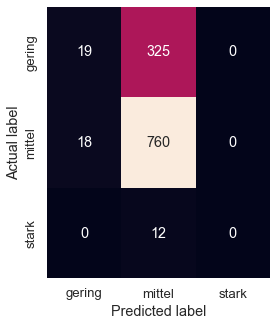


Deciduous
	F1 Score: 0.36860532355658887
	Cohen Kappa Score: 0.40600907211207093
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        63
         1.0       0.46      0.45      0.45       106
         2.0       0.82      0.98      0.89       362
         3.0       1.00      0.33      0.50         9
         4.0       0.00      0.00      0.00         1

    accuracy                           0.75       541
   macro avg       0.45      0.35      0.37       541
weighted avg       0.65      0.75      0.69       541



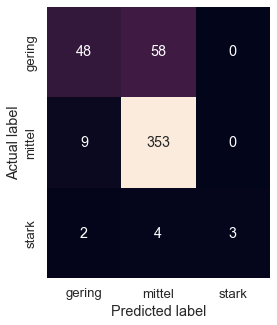


Mixed
	F1 Score: 0.17516750418760468
	Cohen Kappa Score: 0.12368388651434392
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       106
         1.0       0.31      0.02      0.04       179
         2.0       0.72      1.00      0.83       582
         3.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         3

    accuracy                           0.67       871
   macro avg       0.20      0.20      0.18       871
weighted avg       0.54      0.67      0.57       871



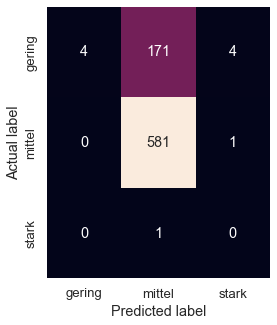

In [76]:
for species in np.unique(np.array([[str(i[0]), str(i[1])] for i in df_relevant_fitted_models_grouped.index])[:, 1]):
    print(f"{species}")
    df_test = data[SPECIES_inverse[species]]['test']
    
    def cascade_results(pred_low, pred_medium, pred_high):
        if pred_medium == 1:
            return 2.0
        elif pred_high == 1:
            return 3.0
        else:
            return 1.0

    df_test["cascaded_prediction"] = df_test.apply(lambda x: cascade_results(x["is_low_pred"], x["is_medium_pred"], x["is_high_pred"]), axis=1)
    
    #tn, fp, fn, tp = metrics.confusion_matrix(df_test["damage_class_group"], df_test["cascaded_prediction"]).ravel()
    #print(f"\ttn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")
    print(f"\tF1 Score: {metrics.f1_score(df_test['damage_class'], df_test['cascaded_prediction'], average='macro')}")
    print(f"\tCohen Kappa Score: {metrics.cohen_kappa_score(df_test['damage_class'], df_test['cascaded_prediction'])}")
    print(metrics.classification_report(df_test['damage_class'], df_test['cascaded_prediction']))
    
    sns.set(font_scale=1.2)
    
    labels = [1.0,2.0,3.0]
    labels_translated = ['gering', 'mittel', 'stark']
    cm = metrics.confusion_matrix(df_test['damage_class'], df_test['cascaded_prediction'], labels=labels)
    plt.figure(figsize=(4,5))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, yticklabels=labels_translated, xticklabels=labels_translated)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    plt.savefig(f'./IMAGES/{species}_cascaded_damage_class_prediction.eps', format='eps', bbox_inches="tight")  
    
    plt.show()
    
    print()

### Export Meta-Models

In [51]:
df_relevant_fitted_models.to_csv(f"{EXPORT_PATH}/relevant_features_damage_classes.csv", index=False)

In [52]:
df_relevant_fitted_models = pd.read_csv(f"{EXPORT_PATH}/relevant_features_damage_classes.csv")
df_relevant_fitted_models["features"] = df_relevant_fitted_models["features"].apply(literal_eval)
df_relevant_fitted_models["predictions"] = df_relevant_fitted_models["predictions"].apply(literal_eval)

df_relevant_fitted_models_reindex = df_relevant_fitted_models.set_index(["species", "target"]).sort_values(by=["species", "target"])
df_relevant_fitted_models_reindex

name source  \
species   target                                             
Conifer   is_high                RUSBoostClassifier     v3   
          is_high            DecisionTreeClassifier     v3   
          is_high    BalancedRandomForestClassifier     v4   
          is_low                                SVM     v3   
          is_low                 AdaBoostClassifier     v4   
          is_low                      XGBClassifier     v4   
          is_medium              AdaBoostClassifier     v3   
          is_medium            KNeighborsClassifier     v3   
          is_medium                             SVM     v3   
Deciduous is_high    HistGradientBoostingClassifier     v3   
          is_high            RandomForestClassifier     v4   
          is_high              KNeighborsClassifier     v3   
          is_low                                SVM     v4   
          is_low             RandomForestClassifier     v4   
          is_low                      XGBClassifier     v3   
          is_medium                             SVM     v4   
          is_medium  HistGradientBoostingClassifier     v3   
          is_medium          DecisionTreeClassifier     v3   
Mixed     is_high    BalancedRandomForestClassifier     v4   
          is_high                RUSBoostClassifier     v4   
          is_high                AdaBoostClassifier     v4   
          is_low             DecisionTreeClassifier     v3   
          is_low                 RUSBoostClassifier     v3   
          is_low                                SVM     v3   
          is_medium          DecisionTreeClassifier     v4   
          is_medium              RUSBoostClassifier     v4   
          is_medium                   XGBClassifier     v4   

                                                              features  \
species   target                                                         
Conifer   is_high    [location_cluster_4, location_cluster_5, locat...   
          is_high    [location_cluster_5, location_cluster_6, locat...   
          is_high    [location_cluster_2, location_cluster_5, locat...   
          is_low     [location_cluster_0, location_cluster_1, locat...   
          is_low     [location_cluster_0, location_cluster_1, locat...   
          is_low     [location_cluster_2, location_cluster_3, locat...   
          is_medium  [location_cluster_0, location_cluster_3, locat...   
          is_medium  [location_cluster_0, location_cluster_1, locat...   
          is_medium  [location_cluster_0, location_cluster_1, locat...   
Deciduous is_high    [location_cluster_0, location_cluster_4, locat...   
          is_high    [location_cluster_1, location_cluster_2, locat...   
          is_high    [location_cluster_3, location_cluster_5, locat...   
          is_low     [location_cluster_5, tree_1, evi2, evi2-1, evi...   
          is_low     [location_cluster_2, location_cluster_4, locat...   
          is_low     [location_cluster_3, location_cluster_4, locat...   
          is_medium  [location_cluster_4, location_cluster_5, locat...   
          is_medium  [location_cluster_0, location_cluster_1, locat...   
          is_medium  [location_cluster_5, location_cluster_7, locat...   
Mixed     is_high    [location_cluster_3, location_cluster_8, locat...   
          is_high    [location_cluster_0, location_cluster_1, locat...   
          is_high    [location_cluster_0, location_cluster_1, locat...   
          is_low     [location_cluster_5, location_cluster_7, locat...   
          is_low     [location_cluster_5, location_cluster_6, locat...   
          is_low     [location_cluster_5, location_cluster_10, loca...   
          is_medium  [location_cluster_10, location_cluster_11, loc...   
          is_medium  [location_cluster_1, location_cluster_4, locat...   
          is_medium  [location_cluster_0, location_cluster_2, locat...   

                                                                  file  \
species   target           

In [53]:
def rename_path(path):
    return path.replace("./results/FINAL", EXPORT_PATH)
    
df_relevant_fitted_models["file"] = df_relevant_fitted_models["file"].apply(rename_path)

In [54]:
import geopandas as gpd
df_wze = gpd.read_file("./data/wze_observations.geojson")
df_wze = df_wze.loc[df_wze["year"] >= 2015]
df_wze

,id,year,tree_age,nbv_perc,damage_class,sat,id_tree,bhd,damage_class_group,tree_sp_fam,tree_sp_cat_id,tree_sp_id,tree_sp_fam_id,x,y,sdi,tree_area_m2,tree_width,geometry
600,SH_10003,2015,149.0,15.0,1.0,na,SH_10003_5,294.877350,damaged,Buche,1,229,102,595422.931867,5.940904e+06,231.845169,43.132234,6.567514,POINT (595422.932 5940904.097)
601,SH_10003,2015,149.0,25.0,1.0,na,SH_10003_21,233.703201,damaged,Buche,1,229,102,595422.931867,5.940904e+06,351.435365,28.454734,5.334298,POINT (595422.932 5940904.097)
602,SH_10003,2015,139.0,25.0,1.0,na,SH_10003_22,322.917480,damaged,Fichte,2,214,208,595422.931867,5.940904e+06,304.269341,32.865618,5.732854,POINT (595422.932 5940904.097)
603,SH_10003,2015,139.0,30.0,2.0,na,SH_10003_23,402.832764,damaged,Kiefer,2,215,209,595422.931867,5.940904e+06,273.793263,36.523908,6.043501,POINT (595422.932 5940904.097)
604,SH_10003,2015,139.0,10.0,0.0,na,SH_10003_3,660.208374,healthy,Kiefer,2,215,209,595422.931867,5.940904e+06,124.633463,80.235273,8.957414,POINT (595422.932 5940904.097)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308566,BW_522,2021,127.0,10.0,0.0,N,BW_522_N19,380.000000,healthy,Kiefer,2,215,209,459960.631422,5.438284e+06,300.463189,33.281947,5.769051,POINT (459960.631 5438283.538)
308567,BW_522,2021,127.0,20.0,1.0,N,BW_522_N18,377.000000,damaged,Kiefer,2,215,209,459960.631422,5.438284e+06,304.280955,32.864364,5.732745,POINT (459960.631 5438283.538)
308568,BW_522,2021,127.0,20.0,1.0,N,BW_522_N17,297.000000,damaged,Kiefer,2,215,209,459960.631422,5.438284e+06,444.923677,22.475765,4.740861,POINT (459960.631 5438283.538)
308569,BW_522,2021,127.0,100.0,4.0,N,BW_522_N16,257.000000,dead,Kiefer,2,215,209,459960.631422,5.438284e+06,560.225763,17.849947,4.224920,POINT (459960.631 5438283.538)


In [55]:
df_inspect = list() #pd.DataFrame([], columns=["id", "year", "std", "mean", "median", "min", "max", "q25", "q75"])

for target in np.unique(np.array([[str(i[0]), str(i[1])] for i in df_relevant_fitted_models_grouped.index])[:, 0]):
    for species in np.unique(np.array([[str(i[0]), str(i[1])] for i in df_relevant_fitted_models_grouped.index])[:, 1]):
        print(f"{target} -> {species}")
        # test data that has been predicted using voting
        df_test = data[SPECIES_inverse[species]]["test"]
        for group_name, df_group in df_test.groupby(["observation_id"]):
            df_test.at[df_group.index, f"{target}_f1"] = metrics.f1_score(df_group[f"{target}"], df_group[f"{target}_pred"])
            df_test.at[df_group.index, f"{target}_cohen_kappa"] = metrics.cohen_kappa_score(df_group[f"{target}"], df_group[f"{target}_pred"])
        
        # identify bad predictions where f1 score is less than 0.5
        df_test_bad_pred = df_test.loc[df_test[f"{target}_f1"] < 0.5]
        
        # get orignial data (no geo areas applied yet)
        df_original_data = df_wze.loc[df_wze["id"].isin(df_test_bad_pred["observation_id"].unique())]
        
        for group_name, df_group in df_original_data.groupby(["id"]):
            df_original_data_filtered = df_group.loc[(df_group["year"].isin(df_test_bad_pred.loc[df_test_bad_pred["observation_id"] == group_name]["year"].unique())) & (df_group["sat"].isin(df_test_bad_pred.loc[df_test_bad_pred["observation_id"] == group_name]["sat"].unique()))]
            df_inspect.append(df_original_data_filtered.groupby(["id", "year", "sat"]).agg({"damage_class": ["min", "max", "mean", "std", "median", ("q25", lambda x: x.quantile(0.25)), ("q75", lambda x: x.quantile(0.75))]}).reset_index())
            
        print()

df_inspect = pd.concat(df_inspect, ignore_index=True)
df_inspect

is_high -> Conifer

is_high -> Deciduous

is_high -> Mixed

is_low -> Conifer

is_low -> Deciduous

is_low -> Mixed

is_medium -> Conifer

is_medium -> Deciduous

is_medium -> Mixed



id  year sat damage_class                                       \
                                 min  max      mean       std median  q25   
0     BW_1119  2017   E          0.0  0.0  0.000000  0.000000    0.0  0.0   
1     BW_1119  2017   S          0.0  0.0  0.000000  0.000000    0.0  0.0   
2      BW_117  2015   S          2.0  3.0  2.333333  0.516398    2.0  2.0   
3      BW_117  2015   W          1.0  4.0  2.166667  0.983192    2.0  2.0   
4      BW_117  2017   S          1.0  2.0  1.833333  0.408248    2.0  2.0   
...       ...   ...  ..          ...  ...       ...       ...    ...  ...   
1001   BW_749  2020   W          0.0  0.0  0.000000  0.000000    0.0  0.0   
1002  BW_9729  2017   N          0.0  0.0  0.000000  0.000000    0.0  0.0   
1003  BW_9729  2017   S          0.0  2.0  1.000000  0.632456    1.0  1.0   
1004  BW_9729  2017   W          0.0  3.0  1.000000  1.264911    0.5  0.0   
1005  BW_9814  2015   E          1.0  2.0  1.166667  0.408248    1.0  1.0   

            
       q75  
0     0.00  
1     0.00  
2     2.75  
3     2.00  
4     2.00  
...    ...  
1001  0.00  
1002  0.00  
1003  1.00  
1004  1.75  
1005  1.00  

[1006 rows x 10 columns]

## Explainable AI
### Analyze: Usage of Attributes

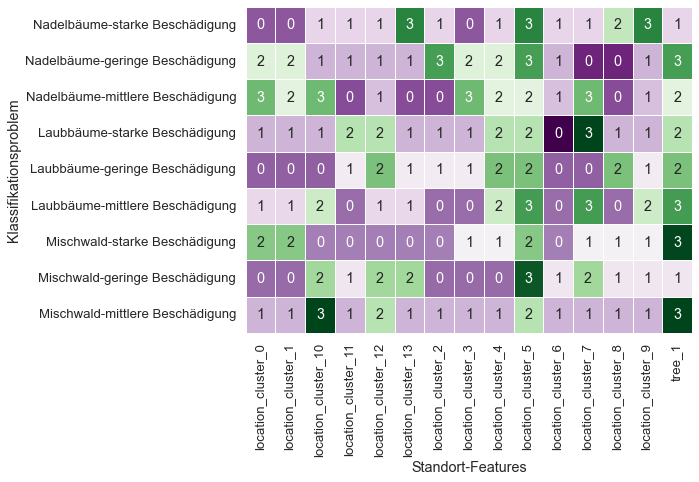

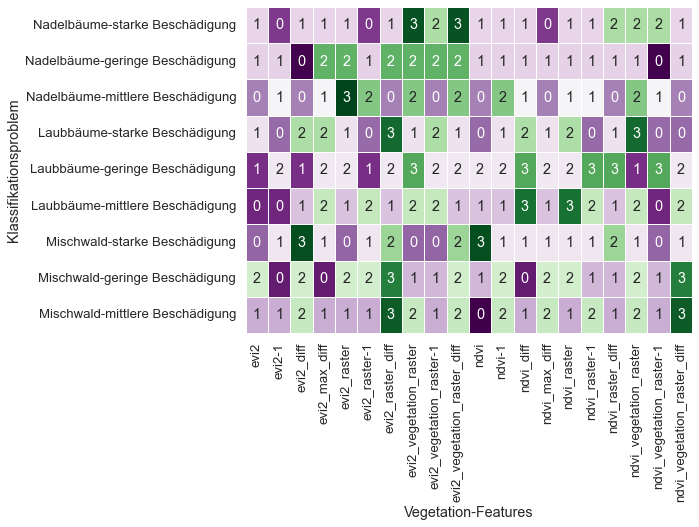

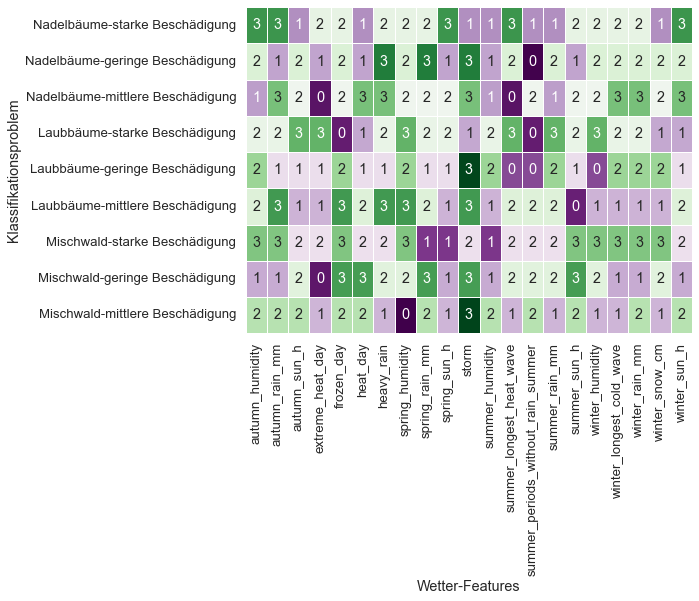

In [58]:
feature_occurances = df_relevant_fitted_models_reindex.explode("features").reset_index().groupby(["species", "target", "features"]).size().reset_index().rename(columns={0: "count"})
feature_occurances = feature_occurances.pivot(columns="features", values="count", index=["species", "target"]).fillna(0)
feature_occurances = feature_occurances.rename({"Conifer":"Nadelbäume", "Deciduous": "Laubbäume", "Mixed": "Mischwald", "is_medium": "mittlere Beschädigung", "is_high": "starke Beschädigung", "is_low": "geringe Beschädigung"})

feature_occurances.reset_index().to_csv("./feature_occurances_damage_classes.csv", index=False)

for col in feature_occurances.columns:
    feature_occurances[col] = feature_occurances[col].astype(int)

groups = dict(
    Standort=[col for col in feature_occurances.columns if "location" in col or "tree" in col],
    Vegetation=[col for col in feature_occurances.columns if "ndvi" in col or "evi" in col],
    Wetter=[col for col in feature_occurances.columns if "location" not in col and "tree" not in col and "ndvi" not in col and "evi" not in col]
)


sns.set(font_scale=1.2)

for i, group in enumerate(groups.keys()):
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(8, 6))

    # normalize by row
    df_norm_row = feature_occurances[groups[group]].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
    # normalize by column
    df_norm_col=(feature_occurances[groups[group]]-feature_occurances[groups[group]].mean())/feature_occurances[groups[group]].std()
    
    ax = sns.heatmap(df_norm_row, annot=feature_occurances[groups[group]], fmt="d", ax=axes, cmap="PRGn", linewidths=.5, cbar=False) #
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_xlabel(f"{group}-Features")
    ax.set_ylabel(f"Klassifikationsproblem")
    
    #plt.savefig(f'./{group}_feature_occurances_damage_group.eps', format='eps', bbox_inches="tight")  
    plt.show()


### Used Models

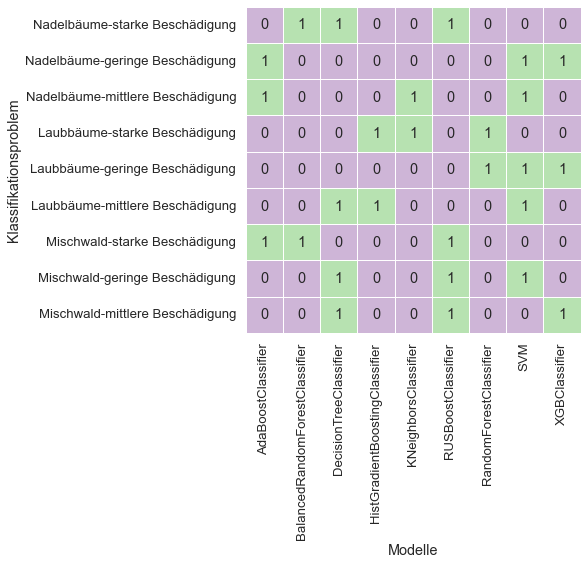

In [59]:
model_occurances = df_relevant_fitted_models_reindex.reset_index().groupby(["species", "target", "name"]).size().reset_index().rename(columns={0: "count"})
model_occurances = model_occurances.pivot(columns="name", values="count", index=["species", "target"]).fillna(0)
model_occurances = model_occurances.rename({"Conifer":"Nadelbäume", "Deciduous": "Laubbäume", "Mixed": "Mischwald", "is_medium": "mittlere Beschädigung", "is_high": "starke Beschädigung", "is_low": "geringe Beschädigung"})

model_occurances.reset_index().to_csv("./model_occurances_damage_classes.csv", index=False)

for col in model_occurances.columns:
    model_occurances[col] = model_occurances[col].astype(int)

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))

ax = sns.heatmap(model_occurances, annot=True, fmt="d", ax=axes, cmap="PRGn", linewidths=.5, cbar=False, vmin=-1, vmax=2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_xlabel(f"Modelle")
ax.set_ylabel(f"Klassifikationsproblem")
    
plt.savefig(f'./used_models_damage_group.eps', format='eps', bbox_inches="tight")
plt.show()

## Validate

Validate Meta-Models by using validation dataset and vote prediction
### Predict Using Meta-Models

In [19]:
master_models = dict()
validation_predictions = dict()

# put models in place
for species in df_relevant_fitted_models["species"].unique():
    master_models[species] = dict()
    validation_predictions[species] = dict()
    
    for target in df_relevant_fitted_models["target"].unique():
        master_models[species][target] = list()
               
        validation_predictions[species][target] = dict(
            single=list(),
            voted=list()
        )
         
        df_sel = df_relevant_fitted_models.loc[(df_relevant_fitted_models["species"] == species) & (df_relevant_fitted_models["target"] == target)]

        for _i, model_row in df_sel.iterrows():
            master_models[species][target].append(dict(
                #model= pickle.load(open(model_row["file"], "rb")),
                file=model_row["file"],
                threshold=model_row["threshold"],
                weight=model_row["cohen_kappa"],
                features=model_row["features"],
            ))
            
            y_pred_proba = pickle.load(open(model_row["file"], "rb")).predict_proba(data[SPECIES_inverse[species]]["validation"][model_row["features"]])
            pred = apply_prediction(y_pred_proba[:, 1], model_row["threshold"])
            validation_predictions[species][target]["single"].append(pred)


In [30]:
for species in validation_predictions:
    for target in validation_predictions[species]:
        print(f"{species} --> {target}")
        
        weights = list()
        voted_preds = np.zeros(data[SPECIES_inverse[species]]["validation"].shape[0])

        for i, model_pred in enumerate(validation_predictions[species][target]["single"]):
            voted_preds += np.array(model_pred) * master_models[species][target][i]["weight"]
            weights.append(master_models[species][target][i]["weight"])

        sum_weights = np.array(weights).sum()

        result = np.where(voted_preds >= sum_weights/(len(weights)/2), 1, 0)
        print(metrics.confusion_matrix(data[SPECIES_inverse[species]]['validation'][target].values, result))
        #tn, fp, fn, tp = metrics.confusion_matrix(data[SPECIES_inverse[species]]['validation'][target].values, result).ravel()
        #print(f"\ttn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")
        print(f"\tF1 Score: {metrics.f1_score(data[SPECIES_inverse[species]]['validation'][target].values, result, average='binary')}")
        print(f"\tCohen Kappa Score: {metrics.cohen_kappa_score(data[SPECIES_inverse[species]]['validation'][target].values, result)}")
        print()
    print("-"*50)

Deciduous --> is_high
[[470   0]
 [  6   0]]
	F1 Score: 0.0
	Cohen Kappa Score: 0.0

Deciduous --> is_medium
[[ 16 122]
 [  4 334]]
	F1 Score: 0.8413098236775819
	Cohen Kappa Score: 0.139364022500287

Deciduous --> is_low
[[260 112]
 [ 20  84]]
	F1 Score: 0.5599999999999999
	Cohen Kappa Score: 0.38419319429198684

--------------------------------------------------
Mixed --> is_high
[[143 365]
 [  0   1]]
	F1 Score: 0.005449591280653952
	Cohen Kappa Score: 0.001537047686098414

Mixed --> is_medium
[[  1 204]
 [  0 304]]
	F1 Score: 0.748768472906404
	Cohen Kappa Score: 0.005821301367239795

Mixed --> is_low
[[ 20 338]
 [ 10 141]]
	F1 Score: 0.44761904761904764
	Cohen Kappa Score: -0.006363202508919974

--------------------------------------------------
Conifer --> is_high
[[679  81]
 [  0   0]]
	F1 Score: 0.0
	Cohen Kappa Score: 0.0

Conifer --> is_medium
[[ 36 348]
 [ 15 361]]
	F1 Score: 0.6654377880184331
	Cohen Kappa Score: 0.053364078069669696

Conifer --> is_low
[[175 391]
 [ 62 132

In [27]:
for species in validation_predictions:
    for target in validation_predictions[species]:
        for i, item in enumerate(validation_predictions[species][target]["single"]):
            if isinstance(validation_predictions[species][target]["single"][i], np.ndarray):
                validation_predictions[species][target]["single"][i] = item.tolist()

In [28]:
with open(f"{EXPORT_PATH}/validation_predictions_damage_classes.json", "w") as fp:
    json.dump(validation_predictions, fp)

In [28]:
with open(f"{EXPORT_PATH}/validation_predictions_damage_classes.json") as fp:
    validation_predictions = json.loads(fp.read())

In [30]:
with open(f"{EXPORT_PATH}/master_models_damage_classes.json", "w") as fp:
    json.dump(master_models, fp)

In [29]:
with open(f"{EXPORT_PATH}/master_models_damage_classes.json") as fp:
    master_models = json.loads(fp.read())